In [145]:
import torch

from fastai.vision.all import *
import torch.nn.functional as F

import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve, accuracy_score, balanced_accuracy_score, average_precision_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [146]:
print(torch.cuda.is_available())

True


In [147]:
%%sh

envName=aml
envPath=~/SageMaker/kernels/$envName
ymlPath=environment.yml  # Update this with the actual path to your environment.yml

# Check if the environment already exists
if [ ! -d "$envPath" ]; then
    # Create the environment from the environment.yml file
    conda env create --prefix $envPath --file $ymlPath
    # Alternatively, to create an empty environment, uncomment the next line
    # conda create --prefix $envPath

    # Create a symlink if your Conda doesn't automatically recognize environments in custom locations
    ln -s $envPath ~/ec2-user/anaconda3/envs/$envName
fi

# Export the Conda environment to a Jupyter Notebook kernel
python -m ipykernel install --user --name $envName --display-name "$envName"

Installed kernelspec aml in /home/ec2-user/.local/share/jupyter/kernels/aml


### Helper Functions


In [148]:
# Plotting Precision-Recall curve for a specific class
def plot_precision_recall_curve(class_index, preds, targets):
    # Convert targets to one-hot format
    one_hot_targets = np.eye(preds.shape[1])[targets.numpy().astype(int)]

    # Extract the relevant column for the class
    class_targets = one_hot_targets[:, class_index]
    class_preds = preds[:, class_index]

    precision, recall, _ = precision_recall_curve(class_targets, class_preds)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.')
    plt.title(f'Precision-Recall Curve for Class {class_index}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()


def per_class_accuracy(preds, targets, class_index):
    class_preds = preds.argmax(dim=1)
    class_correct = (class_preds == class_index) & (targets == class_index)
    class_total = (targets == class_index).sum()
    if class_total == 0:
        return 0  # To handle the case where there are no samples for the class
    acc = class_correct.sum().float() / class_total
    return acc

def plot_class_distribution(df, label_col, save_path=None):
    """
    Plots a histogram for the distribution of class labels in the dataset.

    Parameters:
    df (DataFrame): A pandas DataFrame containing the dataset.
    label_col (str): The name of the column in the DataFrame that contains the class labels.
    save_path (str): Optional. The file path where the plot will be saved. If None, the plot is not saved.
    """
    plt.figure(figsize=(15, 8))
    df[label_col].value_counts().plot(kind='bar')
    plt.title('Class Distribution in Training Data')
    plt.xlabel('Class Label')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90)  # Rotate labels for better readability if necessary

    if save_path:
        plt.savefig(save_path, format='png', bbox_inches='tight')
        plt.close()  # Close the figure after saving to free memory
    else:
        plt.show()

        
def evaluate_model(learner, dls, test_df):
    # Plot top losses
    interp = ClassificationInterpretation.from_learner(learner)
    interp.plot_top_losses(9, figsize=(15, 10))
    plt.show()  # Ensure the plot displays

    # Show results for a few items
    learner.show_results()

    # Get predictions for the test set
    test_dl = dls.test_dl(test_df, with_labels=True)
    predictions, targets = learner.get_preds(dl=test_dl)
    
    # Calculate and print accuracy
    acc = accuracy(predictions, targets)
    print(f"Accuracy: {acc.item() * 100:.2f}%")

    # Plot histogram of predicted classes
    class_preds = predictions.argmax(dim=1).numpy()
    plt.hist(class_preds, bins=len(dls.vocab))
    plt.title("Histogram of Predicted Classes")
    plt.xlabel("Class")
    plt.ylabel("Number of Predictions")
    plt.show()

    # Create a submission DataFrame
    predicted_labels = class_preds
    submission_df = test_df.copy()
    submission_df["label"] = predicted_labels

    # Save the submission file
    submission_file_path = "/mnt/data/submission.csv"  # Adjust path as needed
    submission_df.to_csv(submission_file_path, index=False)
    print(f"Submission file saved to: {submission_file_path}")
    
    return submission_df  # Return the submission DataFrame

### Attributes


In [149]:
class_names = np.load("class_names.npy", allow_pickle=True)
# print(class_names.item())

attributes = np.load("attributes.npy", allow_pickle=True)
attributes.shape

(200, 312)

In [156]:
# Assuming train_df is your DataFrame with the training data
image_files = train_df['image_path'].values  # This will give you an array of image paths
labels = train_df['label'].values  # This will give you an array of labels

# Split the data into training and validation sets
train_files, valid_files, train_labels, valid_labels = train_test_split(
    image_files, labels, test_size=0.2, random_state=42, stratify=labels
)

In [157]:
# Define a custom dataset
class ImageAttributeDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, attributes, is_train=True):
        self.image_files = image_files
        self.labels = labels
        self.attributes = attributes
        self.is_train = is_train

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, i):
        # Get image
        image = PILImage.create(self.image_files[i])
        # Get label
        label = self.labels[i]
        # Get attributes for the class of the label
        attribute = torch.tensor(self.attributes[label], dtype=torch.float32)
        
        # Apply transformations
        if self.is_train:
            image = image.apply_tfms(ImageDataLoaders.train_tfms)
        else:
            image = image.apply_tfms(ImageDataLoaders.valid_tfms)
        
        return image, attribute, label

In [159]:
# Create datasets
train_ds = ImageAttributeDataset(train_files, train_labels, attributes, is_train=True)
valid_ds = ImageAttributeDataset(valid_files, valid_labels, attributes, is_train=False)



### Load CSV Files

In [160]:
train_df = pd.read_csv("train_images.csv")
test_df = pd.read_csv("test_images_path.csv")

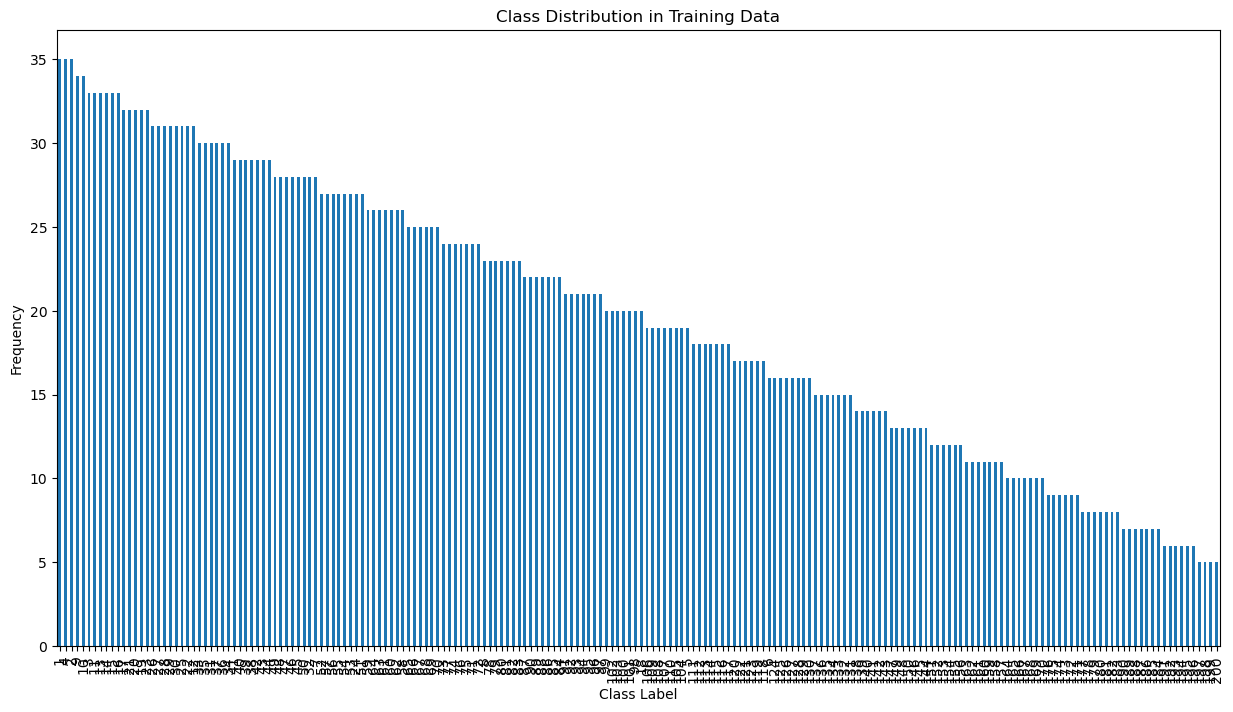

In [161]:
plot_class_distribution(train_df, 'label')

## ImageLoader & DataLoader

In [162]:
dls = ImageDataLoaders.from_df(
    train_df,
    valid_pct=0.2,
    item_tfms=Resize(224),
    bs=96,
    label_col="label",
    fn_col="image_path",
)

In [163]:
# Create dataloaders
dls_custom = DataLoaders.from_dsets(train_ds, valid_ds, bs=64)

## Setup Train

In [164]:
# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_df['label']), y=train_df['label'])
weights = torch.FloatTensor(class_weights).cuda()

In [165]:
dls.train.item_tfms = [
    RandomResizedCrop(224, min_scale=0.5),
    Rotate(),
    Flip(),
    Dihedral(),
    Brightness(),
    Contrast(),
    Saturation(),
    Hue(),
]

### Metrics

In [172]:
f1_score = F1Score(average='macro')
roc_auc = RocAuc()

In [174]:
class BalancedAccuracyMetric(Metric):
    def __init__(self):
        self.preds = []
        self.targets = []

    def reset(self):
        self.preds = []
        self.targets = []

    def accumulate(self, learn):
        preds = learn.pred.argmax(dim=-1).detach().cpu().numpy()
        targs = learn.y.detach().cpu().numpy()
        self.preds.append(preds)
        self.targets.append(targs)

    @property
    def value(self):
        preds = np.concatenate(self.preds)
        targs = np.concatenate(self.targets)
        return balanced_accuracy_score(targs, preds)

balanced_accuracy = BalancedAccuracyMetric()

## Modelling


#### Model 1

In [176]:
learn1 = vision_learner(dls, resnet34, metrics=[accuracy, f1_score, roc_auc], loss_func=CrossEntropyLossFlat(weight=weights))

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fae3a646cb0>
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/aml/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/ec2-user/anaconda3/envs/aml/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1442, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/ec2-user/anaconda3/envs/aml/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/home/ec2-user/anaconda3/envs/aml/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/home/ec2-user/anaconda3/envs/aml/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/home/ec2-user/anaconda3/envs/aml/lib/python3.10/selectors.py", line 416, in select
    fd_

SuggestedLRs(valley=0.0020892962347716093)

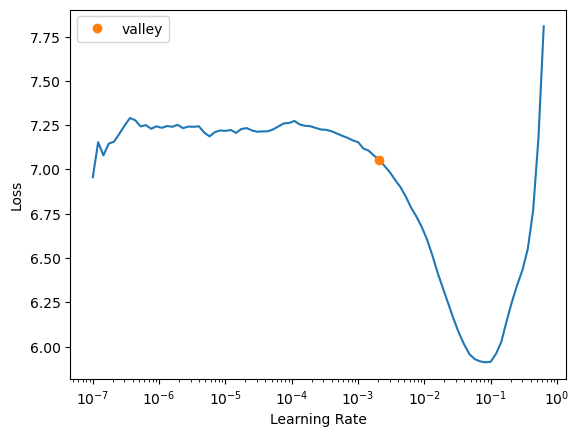

In [177]:
learn1.lr_find()

In [ ]:
learn1.fine_tune(15)

epoch,train_loss,valid_loss,accuracy,f1_score,roc_auc_score,time


#### Model 2

In [116]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        CE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * CE_loss

        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss

focal_loss = FocalLoss(alpha=1.0, gamma=2.0)

In [118]:
learn2 = vision_learner(dls, resnet34, metrics=[accuracy, f1_score, precision_recall_auc, balanced_accuracy], loss_func=focal_loss)

SuggestedLRs(valley=0.0014454397605732083)

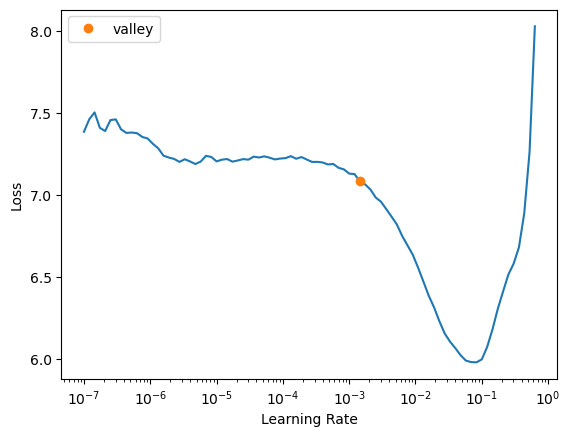

In [119]:
learn2.lr_find()

In [120]:
learn2.fine_tune(15)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,5.936264,3.265202,0.257325,0.171810,00:10


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,3.142335,2.740727,0.321019,0.221852,00:10
1,2.476720,2.189201,0.416561,0.308982,00:10
2,1.817850,1.841357,0.463694,0.367785,00:10
3,1.300221,1.681677,0.519745,0.440337,00:10
4,0.873335,1.529809,0.522293,0.443503,00:10
5,0.567414,1.532282,0.536306,0.443001,00:10
6,0.367928,1.473440,0.551592,0.465275,00:10
7,0.262075,1.522276,0.551592,0.463260,00:10
8,0.181333,1.465602,0.560510,0.493604,00:11
9,0.129284,1.418985,0.564331,0.496475,00:10


### Model 3

In [ ]:
class CombinedModel(nn.Module):
    def __init__(self, image_model, num_attributes):
        super().__init__()
        # Assume image_model is a pre-trained model where the last layer is replaced with an identity mapping
        self.image_model = image_model
        self.attribute_layers = nn.Sequential(
            nn.Linear(num_attributes, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )
        self.final_layers = nn.Sequential(
            nn.Linear(256 + num_output_features_image_model, 200)
        )

    def forward(self, x_image, x_attribute):
        # Pass image through image model
        image_features = self.image_model(x_image)
        
        # Pass attributes through attribute layers
        attribute_features = self.attribute_layers(x_attribute)
        
        # Combine the two feature sets
        combined_features = torch.cat((image_features, attribute_features), dim=1)
        
        # Final classification layer
        out = self.final_layers(combined_features)
        return out

In [ ]:
# Initialize the combined model
image_model = vison_learner(dls_custom, resnet34, pretrained=True, cut=-1)  # Use the model but cut off the head
combined_model = CombinedModel(image_model.model, num_attributes=312)

# Create a learner with the combined model
learn3 = Learner(dls_custom, combined_model, loss_func=CrossEntropyLossFlat())

In [ ]:
learn3.lr_find()

In [ ]:
learn3.fine_tune(15)

### Result

In [ ]:
submission_df = evaluate_model(learn1 dls, test_df)

In [115]:
torch.cuda.empty_cache()